# ResNet
论文笔记：
当模型层次更深时，错误率提高，但是不是由于过拟合引起的，因为随着层数增加，训练error也增加，作者认为准确度降低表明不是所有系统都很容易优化，所以添加了一个恒等映射，将原始需要学得H(x)转化成F(x)+x,作者假设优化残差比学习原始要容易，如果恒等映射最优，将残差直接设成0比继续用非线性层修正恒等映射容易。并且resnet与vgg相比，计算量减小，随着网络层数增加，误差没有出现之前的提高的现象。
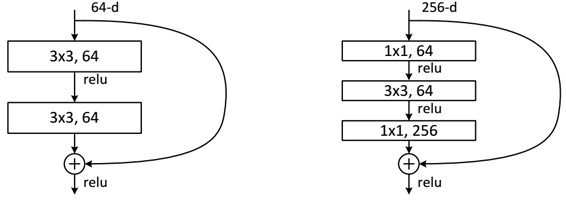
作者又提出更深的residual function，加了个1x1卷积减少了参数，并且更深了。<br/>
这个层结构在反向传播时，将反向的梯度传到x和F(x)上，避免了梯度消失。而且这种结构，如果x已经学的足够好了，F(x)就简单set为0就可以了，所以更简单。

In [10]:
import numpy as np
import torch
from torch import nn,optim
from torch.utils.data import DataLoader,sampler
from torch.autograd import Variable
from torchvision import datasets,transforms

In [3]:
def conv3x3(in_channel,out_channel,stride=1):
    return nn.Conv2d(in_channel,out_channel,3,stride=stride,padding=1,bias=False)

In [4]:
class BasicBlock(nn.Module):
    def __init__(self,in_channel,out_channel,stride=1):
        super(BasicBlock,self).__init__()
        self.stride=stride
        
        self.conv1=conv3x3(in_channel,out_channel,stride)
        self.bn1=nn.BatchNorm2d(out_channel)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=conv3x3(out_channel,out_channel)
        self.bn2=nn.BatchNorm2d(out_channel)
        if stride!=1:
            self.conv3=nn.Conv2d(in_channel,out_channel,1,stride=stride)
        
    def forward(self,x):
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        
        if self.stride!=1:
            x=self.conv3(x)
        out+=x
        out=self.relu(out)
        return out

In [5]:
#测试输入输出
model=BasicBlock(32,32,1)
test_x=Variable(torch.zeros(1,32,96,96))
test_y=model(test_x)
print('input size:{}'.format(test_x.shape))
print('output size:{}'.format(test_y.shape))

input size:torch.Size([1, 32, 96, 96])
output size:torch.Size([1, 32, 96, 96])


In [6]:
class resnet(nn.Module):
    def __init__(self,in_channel,num_classes):
        super(resnet,self).__init__()
        self.block1=nn.Conv2d(in_channel,64,7,2)
        
        self.block2=nn.Sequential(
            nn.MaxPool2d(3,2),
            BasicBlock(64,64),
            BasicBlock(64,64)
        )
        
        self.block3=nn.Sequential(
            BasicBlock(64,128,2),
            BasicBlock(128,128)
        )
        
        self.block4=nn.Sequential(
            BasicBlock(128,256,2),
            BasicBlock(256,256)
        )
        
        self.block5=nn.Sequential(
            BasicBlock(256,512,2),
            BasicBlock(512,512),
            nn.AvgPool2d(3)
        )
        
        self.classifier=nn.Linear(512,num_classes)
        
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

In [20]:
#使用CIFAR10数据集进行训练

def tf(x):
    x=x.resize((96,96),2)
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.transpose((2, 0, 1)) # 将 channel 放到第一维，只是 pytorch 要求的输入方式
    x = torch.from_numpy(x)
    return x

train_set=datasets.CIFAR10('./data',train=True,transform=tf,download=True)
test_set=datasets.CIFAR10('./data',train=False,transform=tf,download=True)

train_data=DataLoader(train_set,batch_size=64,shuffle=False)
test_data=DataLoader(test_set,batch_size=128,shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [21]:
model=resnet(3,10)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)

In [22]:
for epoch in range(20):
    for im,label in train_data:
        im=Variable(im)
        label=Variable(label)
        out=model(im)
        
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

KeyboardInterrupt: 

应该是可以快一点的吧，等了好久也没有跑出来...<br/>
Q：怎样在DataLoader里只选取部分数据用来测试？好像理解错了sampler参数的含义